In [7]:
from models.stage1.vq import VectorQuantize
from utils import load_yaml_param_settings
import numpy as np
import pandas
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
conf_dir = 'configs/config.yaml'

config = load_yaml_param_settings(conf_dir)

In [8]:
dim = 64
vq = VectorQuantize(dim, config["VQVAE"]["codebook"]["size"], **config["VQVAE"])

In [9]:
dim = 64
vq = VectorQuantize(dim, config["VQVAE"]["codebook"]["size"], **config["VQVAE"])

codebook = vq.codebook

codebook_norm = codebook / torch.norm(codebook, dim=1, keepdim=True)

corr = torch.corrcoef(codebook_norm)
torch.sum(torch.abs(corr - torch.eye(corr.shape[0]))) / (corr.shape[0] * (corr.shape[0] - 1))

tensor(0.1057)

In [10]:
cosine_similarity = F.cosine_similarity(codebook_norm.unsqueeze(0), codebook_norm.unsqueeze(1), dim=2)
torch.sum(torch.abs(cosine_similarity - torch.eye(cosine_similarity.shape[0]))) / (cosine_similarity.shape[0] * (cosine_similarity.shape[0] - 1))

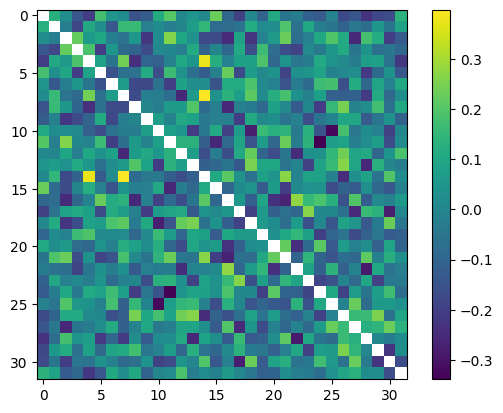

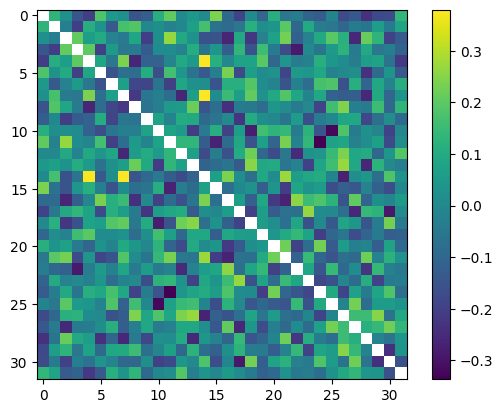

In [18]:
corr.fill_diagonal_(np.nan)
cosine_similarity.fill_diagonal_(np.nan)

plt.imshow(cosine_similarity)
plt.colorbar()
plt.show()
plt.close()
plt.imshow(corr)
plt.colorbar()
plt.show()

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])